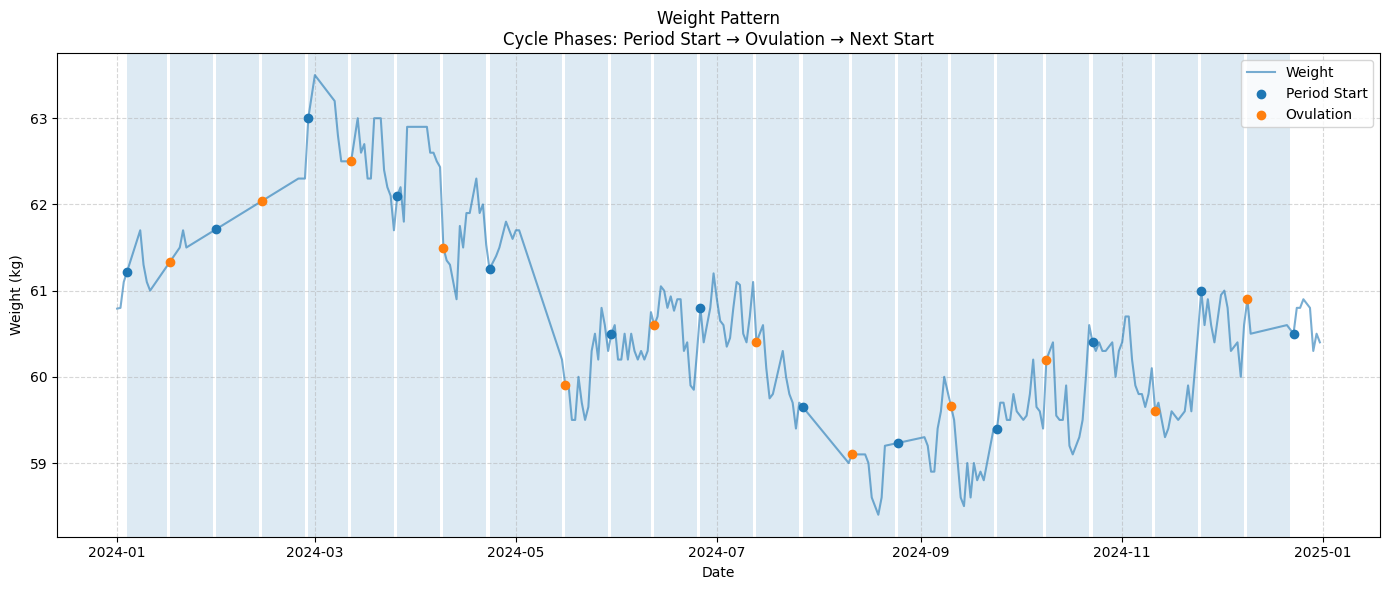

=== Period Start ===
{'n_cycles_total': 120, 'n_cycles_used_for_ttest': 50, 'before_mean': 59.32232452539809, 'after_mean': 59.48305731292517, 'mean_diff': 0.1607327875270812, 't_stat': -2.3938783789973033, 'p_value': 0.020543945280402636}


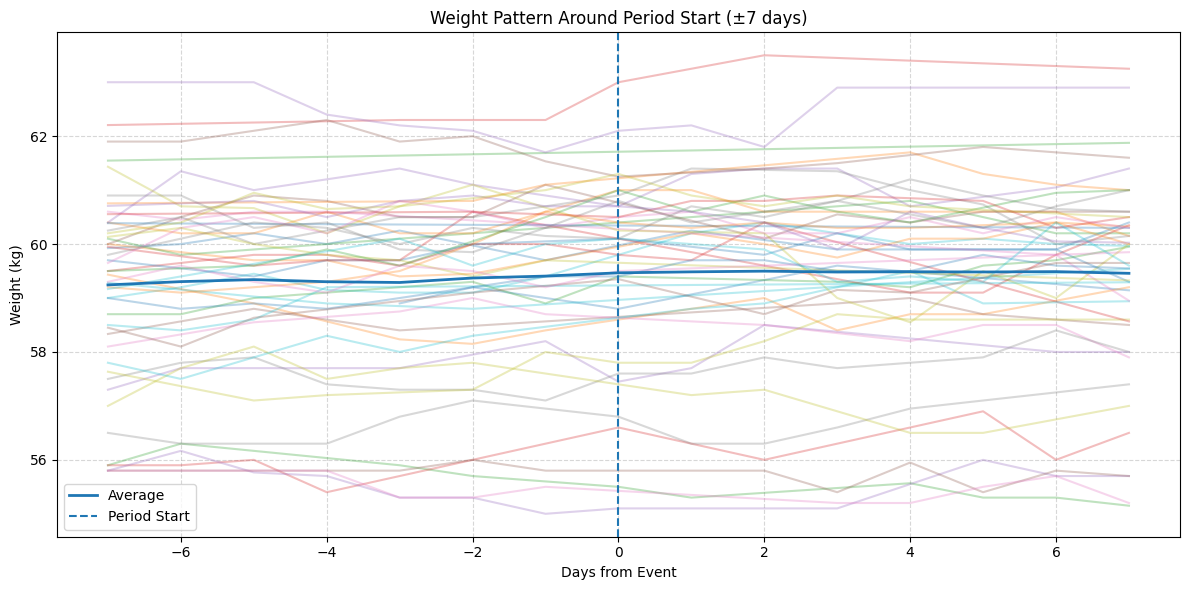

=== Ovulation ===
{'n_cycles_total': 120, 'n_cycles_used_for_ttest': 50, 'before_mean': 59.3336537414966, 'after_mean': 59.21703081477346, 'mean_diff': -0.11662292672313868, 't_stat': 1.199463737273561, 'p_value': 0.23611564750100206}


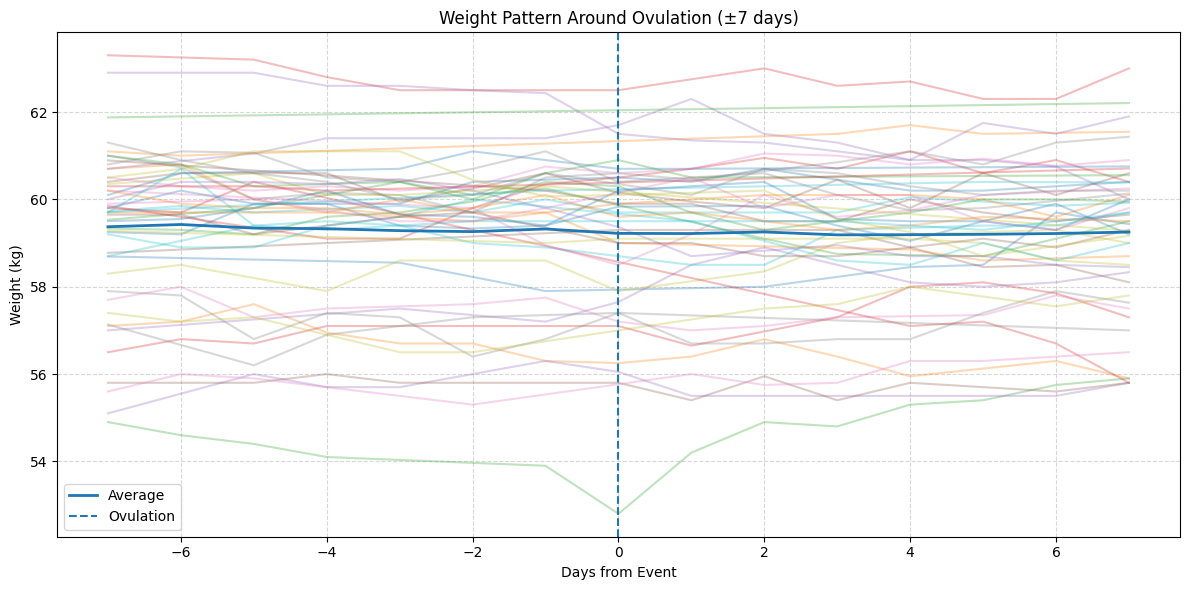

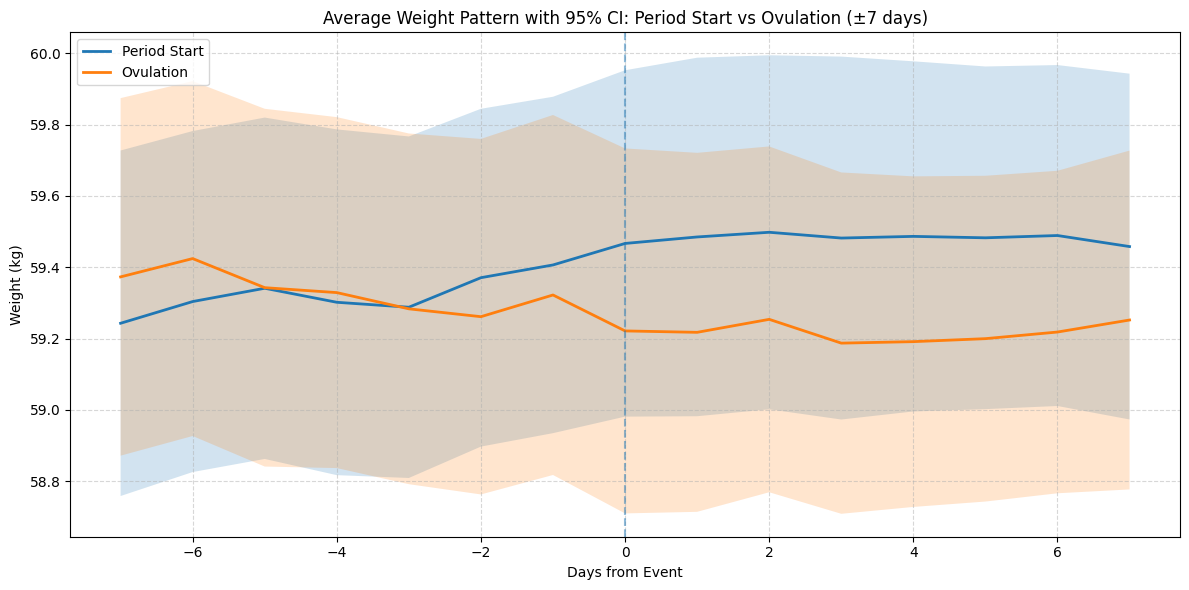

In [60]:
import argparse
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel


# =========================
# Utils: IO
# =========================
def load_periods():
    """Load cleaned_periods.csv / .pkl.
    Required columns: begin, end, ovulation_date
    """
    if Path("cleaned_periods.pkl").exists():
        df = pd.read_pickle("cleaned_periods.pkl")
    elif Path("cleaned_periods.csv").exists():
        df = pd.read_csv("cleaned_periods.csv", parse_dates=["begin", "end", "ovulation_date"])
    else:
        raise FileNotFoundError("cleaned_periods.csv or cleaned_periods.pkl is required.")
    if df["ovulation_date"].dtype == "O":
        df["ovulation_date"] = pd.to_datetime(df["ovulation_date"], errors="coerce")
    return df


def load_weights():
    """Load cleaned_weights.csv / .pkl.
    Required columns: Date, Weight
    """
    if Path("cleaned_weights.pkl").exists():
        df = pd.read_pickle("cleaned_weights.pkl")
    elif Path("cleaned_weights.csv").exists():
        df = pd.read_csv("cleaned_weights.csv", parse_dates=["Date"])
    else:
        raise FileNotFoundError("cleaned_weights.csv or cleaned_weights.pkl is required.")
    return df


# =========================
# Plot 1: Yearly timeline + cycle shading
# =========================
def plot_weight_timeline(df_weight_year, df_periods_year, outpath, show=False):
    plt.figure(figsize=(14, 6))
    plt.plot(df_weight_year["Date"], df_weight_year["Weight"], label="Weight", alpha=0.6)

    period_starts = df_periods_year["begin"].dropna().sort_values().tolist()
    ovulations = df_periods_year.set_index("begin")["ovulation_date"].to_dict()

    for i in range(len(period_starts) - 1):
        start = period_starts[i]
        ovul = ovulations.get(start, None)
        next_start = period_starts[i + 1]

        if pd.notna(ovul) and ovul > start:
            plt.axvspan(start, ovul - pd.Timedelta(days=1), alpha=0.15)
            plt.axvspan(ovul, next_start - pd.Timedelta(days=1), alpha=0.15)
        else:
            plt.axvspan(start, next_start - pd.Timedelta(days=1), alpha=0.15)

    y_for_begin = df_weight_year.set_index("Date").reindex(df_periods_year["begin"])["Weight"]
    plt.scatter(df_periods_year["begin"], y_for_begin, label="Period Start", zorder=3)

    y_for_ovul = df_weight_year.set_index("Date").reindex(df_periods_year["ovulation_date"])["Weight"]
    plt.scatter(df_periods_year["ovulation_date"], y_for_ovul, label="Ovulation", zorder=3)

    plt.title("Weight Pattern\nCycle Phases: Period Start → Ovulation → Next Start")
    plt.xlabel("Date")
    plt.ylabel("Weight (kg)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    if show:
        plt.show()
    plt.close()


# =========================
# Align function
# =========================
def align_weight(df_weight, event_dates, window):
    """Align weight data around given event dates ±window days."""
    day_range = np.arange(-window, window + 1)
    aligned = []

    for event_date in event_dates:
        if pd.isna(event_date):
            continue
        start_window = event_date - pd.Timedelta(days=window)
        end_window = event_date + pd.Timedelta(days=window)

        df_window = df_weight[(df_weight["Date"] >= start_window) & (df_weight["Date"] <= end_window)].copy()
        df_window["cycle_day"] = (df_window["Date"] - event_date).dt.days
        df_window = df_window.set_index("cycle_day").reindex(day_range)

        aligned.append(df_window["Weight"].values)

    if not aligned:
        return np.empty((0, len(day_range)), dtype=float)

    return np.array(aligned, dtype=float)


# =========================
# Analysis + visualization
# =========================
def analyze_event_pattern(aligned_data, window, event_name, outpath, show=False):
    day_range = np.arange(-window, window + 1)
    mean_cycle = np.nanmean(aligned_data, axis=0) if aligned_data.size else np.array([])

    def row_safe_mean(a):
        cnt = np.sum(~np.isnan(a), axis=1)
        s = np.nansum(a, axis=1)
        m = np.divide(s, cnt, where=cnt > 0)
        m[cnt == 0] = np.nan
        return m, cnt

    before_slice = aligned_data[:, :window] if aligned_data.size else np.empty((0, 0))
    after_slice = aligned_data[:, window + 1:] if aligned_data.size else np.empty((0, 0))

    before_row_mean, before_cnt = row_safe_mean(before_slice)
    after_row_mean, after_cnt = row_safe_mean(after_slice)

    if aligned_data.size:
        before_mean = np.nanmean(before_slice)
        after_mean = np.nanmean(after_slice)
        mean_diff = after_mean - before_mean
    else:
        before_mean = after_mean = mean_diff = np.nan

    valid = (before_cnt > 0) & (after_cnt > 0)
    if valid.sum() >= 2:
        t_stat, p_value = ttest_rel(before_row_mean[valid], after_row_mean[valid])
    else:
        t_stat = p_value = np.nan

    print(f"=== {event_name} ===")
    print({
        "n_cycles_total": int(aligned_data.shape[0]),
        "n_cycles_used_for_ttest": int(valid.sum()),
        "before_mean": float(before_mean) if pd.notna(before_mean) else None,
        "after_mean": float(after_mean) if pd.notna(after_mean) else None,
        "mean_diff": float(mean_diff) if pd.notna(mean_diff) else None,
        "t_stat": float(t_stat) if pd.notna(t_stat) else None,
        "p_value": float(p_value) if pd.notna(p_value) else None,
    })

    plt.figure(figsize=(12, 6))
    if aligned_data.size:
        for row in aligned_data:
            plt.plot(day_range, row, alpha=0.3)
        plt.plot(day_range, mean_cycle, linewidth=2, label="Average")
    plt.axvline(0, linestyle="--", label=event_name)
    plt.xlabel("Days from Event")
    plt.ylabel("Weight (kg)")
    plt.title(f"Weight Pattern Around {event_name} (±{window} days)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    if show:
        plt.show()
    plt.close()


# =========================
# Comparison: Two events mean + 95% CI
# =========================
def plot_event_comparison_with_ci(aligned1, aligned2, window, label1, label2, outpath, show=False):
    day_range = np.arange(-window, window + 1)

    def mean_ci(data):
        if data.size == 0:
            n = len(day_range)
            return np.full(n, np.nan), np.full(n, np.nan)
        mean = np.nanmean(data, axis=0)
        n_eff = np.sum(~np.isnan(data), axis=0)
        std = np.nanstd(data, axis=0)
        se = np.where(n_eff > 0, std / np.sqrt(n_eff), np.nan)
        ci = 1.96 * se
        return mean, ci

    m1, c1 = mean_ci(aligned1)
    m2, c2 = mean_ci(aligned2)

    plt.figure(figsize=(12, 6))
    plt.plot(day_range, m1, linewidth=2, label=label1)
    if not np.all(np.isnan(c1)):
        plt.fill_between(day_range, m1 - c1, m1 + c1, alpha=0.2)

    plt.plot(day_range, m2, linewidth=2, label=label2)
    if not np.all(np.isnan(c2)):
        plt.fill_between(day_range, m2 - c2, m2 + c2, alpha=0.2)

    plt.axvline(0, linestyle="--", alpha=0.5)
    plt.xlabel("Days from Event")
    plt.ylabel("Weight (kg)")
    plt.title(f"Average Weight Pattern with 95% CI: {label1} vs {label2} (±{window} days)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    if show:
        plt.show()
    plt.close()


# =========================
# Main
# =========================
def main(year: int, window: int, show=False):
    os.makedirs("figures", exist_ok=True)

    df_periods = load_periods()
    df_weight = load_weights()

    df_weight = df_weight.sort_values("Date")
    df_periods = df_periods.sort_values("begin")

    df_weight_year = df_weight[df_weight["Date"].dt.year == year]
    df_periods_year = df_periods[df_periods["begin"].dt.year == year]

    plot_weight_timeline(df_weight_year, df_periods_year, "figures/01_weight_timeline.png", show=show)

    aligned_period = align_weight(df_weight, df_periods["begin"], window)
    aligned_ovul = align_weight(df_weight, df_periods["ovulation_date"], window)

    analyze_event_pattern(aligned_period, window, "Period Start", "figures/02_align_period_start.png", show=show)
    analyze_event_pattern(aligned_ovul, window, "Ovulation", "figures/03_align_ovulation.png", show=show)

    plot_event_comparison_with_ci(aligned_period, aligned_ovul, window,
                                  "Period Start", "Ovulation",
                                  "figures/04_compare_period_vs_ovulation.png", show=show)


if __name__ == "__main__":
    import sys
    if "ipykernel" in sys.modules:  # Jupyter Notebook
        main(year=2024, window=7, show=True)
    else:
        parser = argparse.ArgumentParser(description="Weight × Cycle Analysis")
        parser.add_argument("--year", type=int, default=2024)
        parser.add_argument("--window", type=int, default=7)
        args = parser.parse_args()
        main(year=args.year, window=args.window, show=False)
